#KNN from scratch

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sstats
import seaborn as sns

In [80]:
#Euclidian distance
def euc(train_X, test_X):
  dists = np.sqrt((train_X**2).sum(axis=1).reshape(-1,1) + 
                  (test_X**2).sum(axis=1).reshape(1,-1) - 
                  2*(train_X@test_X.T))
  return dists

In [69]:
def KNN(train_X, train_Y, test_X, ks, method=euc):
    """
    Compute predictions for various k
    Args:
        train_X: array of shape Ntrain x D
        train_Y: array of shape Ntrain
        test_X: array of shape Ntest x D
        ks: list of integers
    Returns:
        preds: dict k: predictions for k
    """
    #Categorize data to float32
    train_X = train_X.astype(np.float32)
    test_X = test_X.astype(np.float32)

    #Euclidean distance
    dists = method(train_X, test_X)
    closest = np.argsort(dists, axis=0)
    targets = train_Y[closest]

    preds = {}
    for k in ks:
        predictions = sstats.mode(targets[:k], axis=0)[0]
        predictions = predictions.ravel()
        preds[k] = predictions
    return preds

In [ ]:
#Testing
iris_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
# Use read_csv to load the data. Make sure you get 150 examples!
iris_df = pd.read_csv(iris_url, header=None)

# Set the column names to
iris_df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target']
iris_df.head()

In [ ]:
unknown_df = pd.DataFrame(
    [[1.5, 0.3, 'unknown'],
     [4.5, 1.2, 'unknown'],
     [5.1, 1.7, 'unknown'],
     [5.5, 2.3, 'unknown']],
     columns=['petal_length', 'petal_width', 'target'])

sns.scatterplot(x='petal_length', y='petal_width', hue='target', data=iris_df)
sns.scatterplot(x='petal_length', y='petal_width', color='gray', marker='v',
                label='unknown', s=70, data=unknown_df)

In [71]:
iris_x = np.array(iris_df[['petal_length', 'petal_width']])
iris_y = np.array(iris_df['target'])
unknown_x = np.array(unknown_df[['petal_length', 'petal_width']])
KNN(iris_x, iris_y, unknown_x, [1,3,5,7])

{1: array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica',
        'Iris-virginica'], dtype=object),
 3: array(['Iris-setosa', 'Iris-versicolor', 'Iris-versicolor',
        'Iris-virginica'], dtype=object),
 5: array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica',
        'Iris-virginica'], dtype=object),
 7: array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica',
        'Iris-virginica'], dtype=object)}

In [ ]:
iris_x = np.array(iris_df[['petal_length', 'petal_width']])
iris_y = np.array(iris_df['target'])
mesh_step = 0.05

mesh_x, mesh_y = np.meshgrid(np.arange(np.min(iris_x[:, 0]), np.max(iris_x[:, 0] + mesh_step), mesh_step),
                             np.arange(np.min(iris_x[:, 1]), np.max(iris_x[:, 1] + mesh_step), mesh_step))

#use np.unique with suitable options to map the class names to numbers
target_names, iris_y_ids = np.unique(iris_y, return_inverse=True)

mesh_data = np.hstack([mesh_x.reshape(-1, 1), mesh_y.reshape(-1, 1)])

ks = [1, 3, 5, 7]
preds = KNN(iris_x, iris_y_ids, mesh_data, ks)
for k, preds_k in preds.items():
    plt.figure()
    plt.title(f"Decision boundary for k={k}")
    plt.contourf(mesh_x, mesh_y, preds_k.reshape(mesh_x.shape), cmap='summer')
    plt.scatter(x='petal_length', y='petal_width', data=iris_df, facecolors='none', edgecolors='blue')

In [34]:
#Error rates
def error_rates(preds, test_Y):
    ret = {}
    for k, preds_k in  preds.items():
        ret[k] = np.sum(preds_k != test_Y) / test_Y.shape[0]
    return ret

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


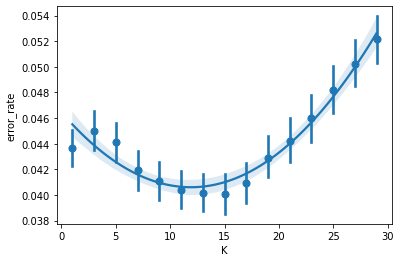

In [35]:
iris_x = np.array(iris_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
iris_y = np.array(iris_df['target'])

ks = range(1, 30, 2)
results = []

for rep in range(1000):
  train_idx = np.random.randint(iris_x.shape[0], size=150)
  test_idx = np.setdiff1d(np.arange(iris_x.shape[0]), train_idx)
  preds = KNN(iris_x[train_idx], iris_y[train_idx], iris_x[test_idx], ks)
  errors = error_rates(preds, iris_y[test_idx])
  for k, errors_k in errors.items():
    results.append({'K':k, 'error_rate':errors_k})

results_df = pd.DataFrame(results)
plt.figure()
sns.regplot('K', 'error_rate', order=2, data=results_df, x_estimator=np.mean)